## Project: Image Captioning

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from model import EncoderCNN, DecoderRNN
import math

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [26]:
## Select appropriate values for the Python variables below.
batch_size = 64               # batch size
vocab_threshold = 5           # minimum word count threshold
vocab_from_file = True        # if True, load existing vocab file
embed_size = 512              # dimensionality of image and word embeddings
hidden_size = 512             # number of features in hidden state of the RNN decoder
num_epochs = 3                # number of training epochs
save_every = 1                # determines frequency of saving model weights
print_every = 200             # determines window for printing average loss
log_file = 'training_log.txt' # name of file with saved training loss and perplexity

# image transform below.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

In [27]:
# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...


100%|██████████| 414113/414113 [01:36<00:00, 4271.95it/s]


Done (t=1.02s)
creating index...
index created!
Obtaining caption lengths...


In [30]:
# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# specify the learnable parameters of the model.
params = list(decoder.parameters()) + list(encoder.embed.parameters()) 

# Define the optimizer.
optimizer = torch.optim.Adam(params) 
                             #lr = 0.001)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

In [ ]:
import torch.utils.data as data
import numpy as np
import os
import requests
import time

from workspace_utils import active_session

with active_session():

    # Open the training log file.
    f = open(log_file, 'w')

    old_time = time.time()
    response = requests.request("GET", 
                            "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token", 
                            headers={"Metadata-Flavor":"Google"})

    for epoch in range(1, num_epochs+1):
    
        for i_step in range(1, total_step+1):
        
            if time.time() - old_time > 60:
                old_time = time.time()
                requests.request("POST", 
                                 "https://nebula.udacity.com/api/v1/remote/keep-alive", 
                                 headers={'Authorization': "STAR " + response.text})
        
            # Randomly sample a caption length, and sample indices with that length.
            indices = data_loader.dataset.get_train_indices()
            # Create and assign a batch sampler to retrieve a batch with the sampled indices.
            new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
            data_loader.batch_sampler.sampler = new_sampler
        
            # Obtain the batch.
            images, captions = next(iter(data_loader))

            # Move batch of images and captions to GPU if CUDA is available.
            images = images.to(device)
            captions = captions.to(device)
        
            # Zero the gradients.
            decoder.zero_grad()
            encoder.zero_grad()
        
            # Pass the inputs through the CNN-RNN model.
            features = encoder(images)
            outputs = decoder(features, captions)
        
            # Calculate the batch loss.
            loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        
            # Backward pass.
            loss.backward()
        
            # Update the parameters in the optimizer.
            optimizer.step()
            
            # Get training statistics.
            stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        
            # Print training statistics (on same line).
            print('\r' + stats, end="")
            sys.stdout.flush()
        
            # Print training statistics to file.
            f.write(stats + '\n')
            f.flush()
        
            # Print training statistics (on different line).
            if i_step % print_every == 0:
                print('\r' + stats)
            
        # Save the weights.
        if epoch % save_every == 0:
            torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pkl' % epoch))
            torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pkl' % epoch))

    # Close the training log file.
    f.close()

Epoch [1/3], Step [200/6471], Loss: 3.7871, Perplexity: 44.13027
Epoch [1/3], Step [400/6471], Loss: 3.2306, Perplexity: 25.2955
Epoch [1/3], Step [600/6471], Loss: 3.1568, Perplexity: 23.4955
Epoch [1/3], Step [800/6471], Loss: 2.7991, Perplexity: 16.4291
Epoch [1/3], Step [1000/6471], Loss: 2.7570, Perplexity: 15.7525
Epoch [1/3], Step [1200/6471], Loss: 2.5558, Perplexity: 12.8819
Epoch [1/3], Step [1400/6471], Loss: 2.8553, Perplexity: 17.3795
Epoch [1/3], Step [1600/6471], Loss: 2.5161, Perplexity: 12.3804
Epoch [1/3], Step [1800/6471], Loss: 2.5973, Perplexity: 13.4278
Epoch [1/3], Step [2000/6471], Loss: 2.4735, Perplexity: 11.86418
Epoch [1/3], Step [2200/6471], Loss: 2.3356, Perplexity: 10.3359
Epoch [1/3], Step [2400/6471], Loss: 2.6214, Perplexity: 13.7548
Epoch [1/3], Step [2600/6471], Loss: 2.4324, Perplexity: 11.3858
Epoch [1/3], Step [2800/6471], Loss: 2.5601, Perplexity: 12.9376
Epoch [1/3], Step [3000/6471], Loss: 2.2784, Perplexity: 9.76127
Epoch [1/3], Step [3200/647

In [4]:
from data_loader_val import get_loader_val

# set transforms
transform_val = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

batch_size = 1

# Data loader
data_loader_val = get_loader_val(transform = transform_val,
                                 mode = 'test')

Vocabulary successfully loaded from vocab.pkl file!


In [6]:
# Load the model
from model import EncoderCNN, DecoderRNN
import numpy as np
import matplotlib.pyplot as plt
import os

# Specify the saved models to load.
encoder_file = 'encoder-3.pkl'
decoder_file = 'decoder-3.pkl'

# Select appropriate values for the Python variables below.
embed_size = 512
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader_val.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 89290679.06it/s]


DecoderRNN(
  (Wemb): Embedding(9955, 512)
  (lstm): LSTM(512, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=9955, bias=True)
)

In [10]:
# Function from id to word
def clean_sentence(output):
    sentence = ""
    
    for i in output:
        if(i == 0):
            continue
        elif(i == 1 or i == 18):
            break
        else:
            sentence = (sentence + 
                        data_loader_val.dataset.vocab.idx2word[i] + 
                        " ")
    return sentence

In [11]:
def get_prediction():
    orig_image, image = next(iter(data_loader_val))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    
    print('Predicted caption: {}'.format(sentence))

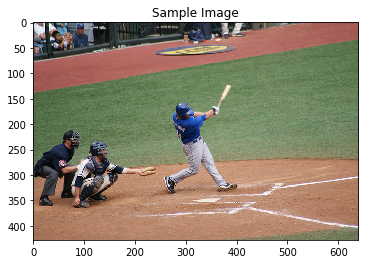

Predicted caption: a baseball player is swinging a bat at a game 


In [14]:
get_prediction()